# Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing


# Datasets Preparation

In [2]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Phytoplankton variables
    flag = ds_bio.flagellates
    diat = ds_bio.diatoms

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, flag, diat)


# Masking

In [3]:
def masking (depth, temp, saline, mask, flag, diat):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    flag = flag.where(mask[0,depth]==1)
    diat = diat.where(mask[0,depth]==1)

    return (temp, saline, flag, diat)

# SOM

In [4]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = inputs[:,indx[:,0]]
    inputs3 = preprocessing.normalize(inputs2, norm= 'max')
    inputs3 = inputs3.transpose()

    # SOM
    temp_som = SOM(m=3, n=2, dim= inputs3[0,:].size, lr = 0.1)
    temp_som.fit(inputs3, epochs = 5)
    predictions = temp_som.predict(inputs3)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2.transpose(), predictions, clusters)


# Printing

In [5]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [6]:
def plotting (depth, clusters, unique, flag, diat):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': flag[0,depth].y, 'x': flag[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    cmap = plt.get_cmap('tab10', unique.max()+1)
    cmap.set_bad('gray')
    fig, ax = plt.subplots(2,2, figsize=(10, 15))
    clus = map.plot.pcolormesh(ax=ax[0,0], cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique)
    cbar.set_label('Clusters [count]')
    
    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.95, 
        wspace=0.15, 
        hspace=0.15)
        
    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')
    flag[0,depth].plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
    diat[0,depth].plot.pcolormesh(ax=ax[1,0], cmap=cmap) 

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])

    ax[0,0].title.set_text('Clustering')
    ax[0,1].title.set_text('Flaggelates')
    ax[1,0].title.set_text('Diatoms')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters, ' + str(date[0].year) + '/' + month + '/' + day)
    
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 11097 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 11.04 degrees Celsius
The mean temperature for cluster 0 is 9.01 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 22.47 g/kg
The mean salinity for cluster 0 is 17.17 g/kg 


The amount of grid boxes for cluster 1 is 6875 

The minimum temperature for cluster 1 is 7.28 degrees Celsius
The maximum temperature for cluster 1 is 10.58 degrees Celsius
The mean temperature for cluster 1 is 9.29 degrees Celsius 

The minimum salinity for cluster 1 is 22.27 g/kg
The maximum salinity for cluster 1 is 25.7 g/kg
The mean salinity for cluster 1 is 23.91 g/kg 


The amount of grid boxes for cluster 2 is 13533 

The minimum temperature for cluster 2 is 7.38 degrees Celsius
The maximum temperature for cluster 2 is 10.53 degrees Celsius
The mean temperature for cluster 2 is 9.03 degrees Celsius 

Th

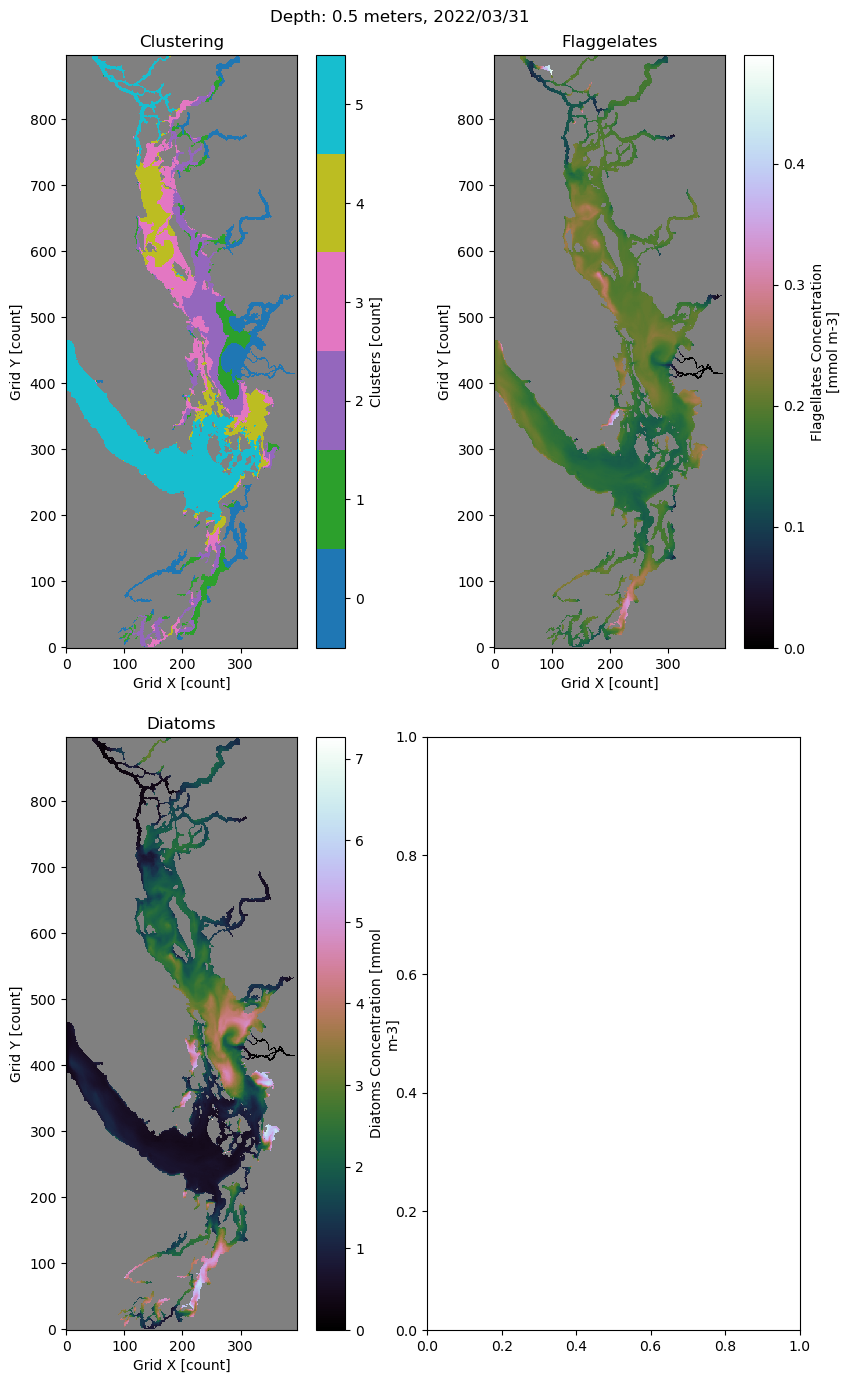

The amount of grid boxes for cluster 0 is 8653 

The minimum temperature for cluster 0 is 7.42 degrees Celsius
The maximum temperature for cluster 0 is 9.72 degrees Celsius
The mean temperature for cluster 0 is 8.4 degrees Celsius 

The minimum salinity for cluster 0 is 27.12 g/kg
The maximum salinity for cluster 0 is 30.67 g/kg
The mean salinity for cluster 0 is 28.68 g/kg 


The amount of grid boxes for cluster 1 is 26438 

The minimum temperature for cluster 1 is 6.72 degrees Celsius
The maximum temperature for cluster 1 is 8.96 degrees Celsius
The mean temperature for cluster 1 is 7.98 degrees Celsius 

The minimum salinity for cluster 1 is 27.93 g/kg
The maximum salinity for cluster 1 is 31.32 g/kg
The mean salinity for cluster 1 is 30.35 g/kg 


The amount of grid boxes for cluster 2 is 14494 

The minimum temperature for cluster 2 is 7.83 degrees Celsius
The maximum temperature for cluster 2 is 10.16 degrees Celsius
The mean temperature for cluster 2 is 8.91 degrees Celsius 

Th

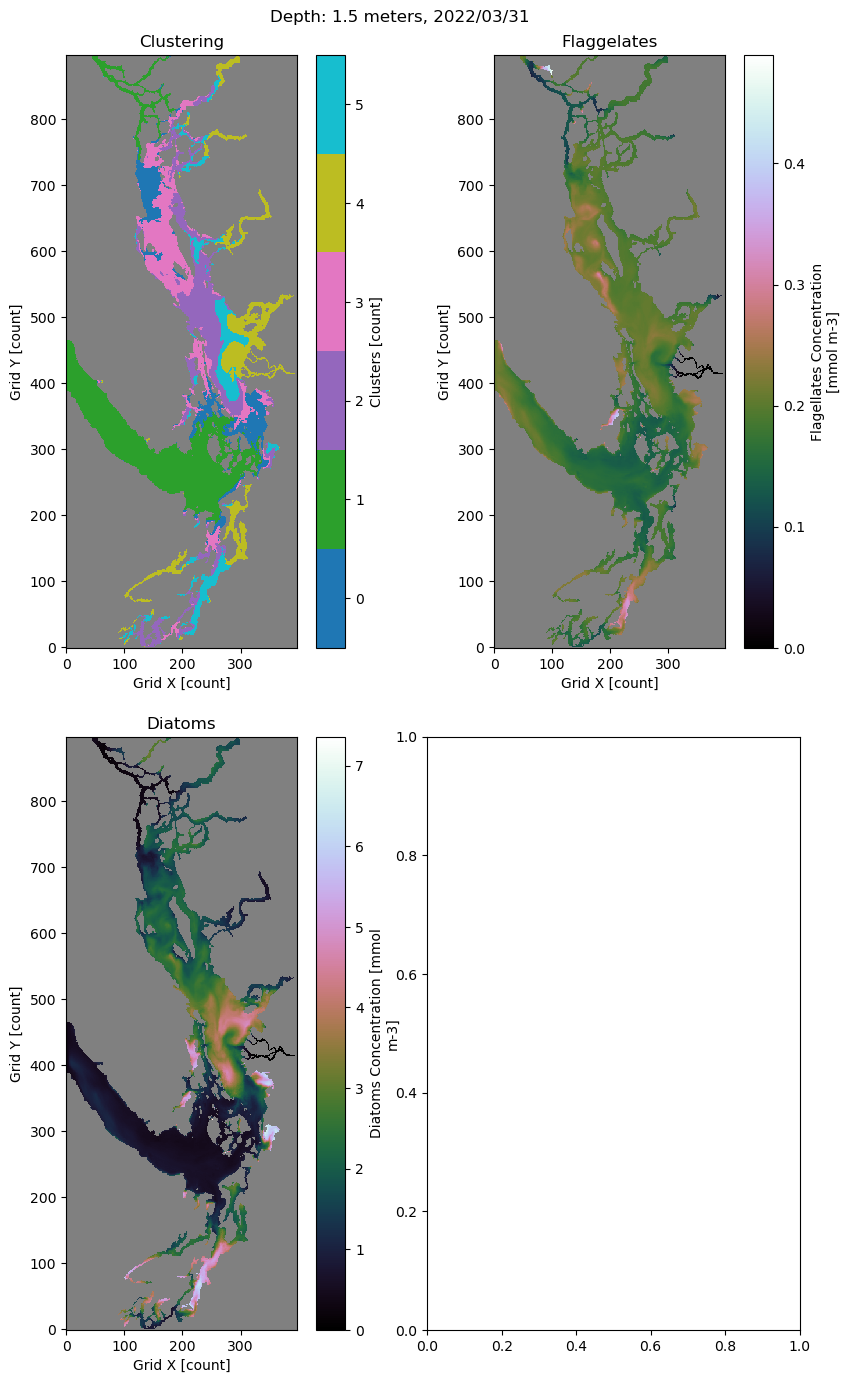

The amount of grid boxes for cluster 0 is 9322 

The minimum temperature for cluster 0 is 7.99 degrees Celsius
The maximum temperature for cluster 0 is 10.88 degrees Celsius
The mean temperature for cluster 0 is 9.25 degrees Celsius 

The minimum salinity for cluster 0 is 22.04 g/kg
The maximum salinity for cluster 0 is 27.01 g/kg
The mean salinity for cluster 0 is 25.14 g/kg 


The amount of grid boxes for cluster 1 is 8928 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 11.12 degrees Celsius
The mean temperature for cluster 1 is 8.93 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 24.57 g/kg
The mean salinity for cluster 1 is 19.01 g/kg 


The amount of grid boxes for cluster 2 is 15371 

The minimum temperature for cluster 2 is 8.46 degrees Celsius
The maximum temperature for cluster 2 is 9.98 degrees Celsius
The mean temperature for cluster 2 is 8.83 degrees Celsius 

The

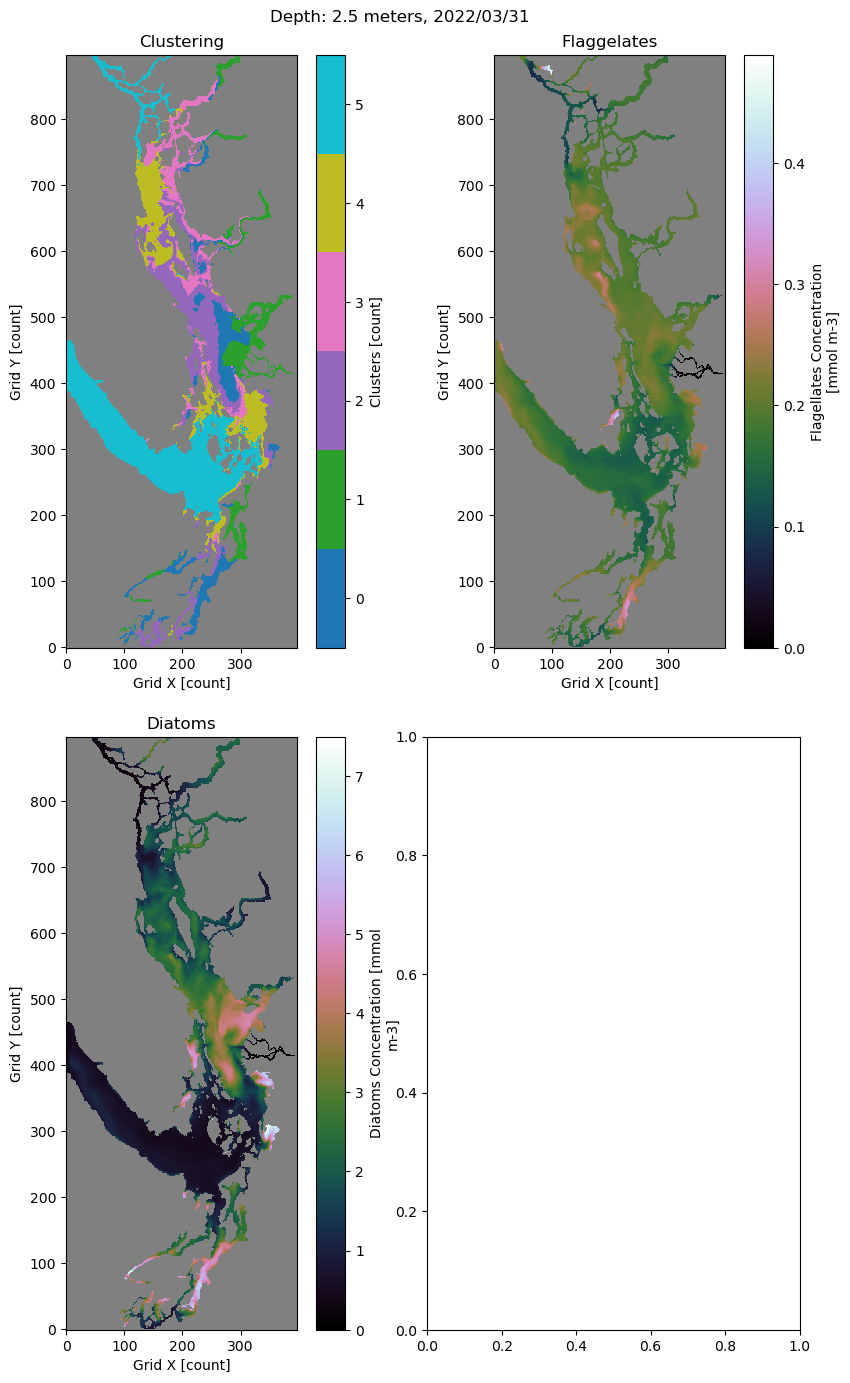

The amount of grid boxes for cluster 0 is 24762 

The minimum temperature for cluster 0 is 6.71 degrees Celsius
The maximum temperature for cluster 0 is 9.13 degrees Celsius
The mean temperature for cluster 0 is 7.95 degrees Celsius 

The minimum salinity for cluster 0 is 29.13 g/kg
The maximum salinity for cluster 0 is 31.33 g/kg
The mean salinity for cluster 0 is 30.47 g/kg 


The amount of grid boxes for cluster 1 is 6500 

The minimum temperature for cluster 1 is 7.01 degrees Celsius
The maximum temperature for cluster 1 is 8.51 degrees Celsius
The mean temperature for cluster 1 is 8.12 degrees Celsius 

The minimum salinity for cluster 1 is 27.37 g/kg
The maximum salinity for cluster 1 is 29.53 g/kg
The mean salinity for cluster 1 is 28.92 g/kg 


The amount of grid boxes for cluster 2 is 16792 

The minimum temperature for cluster 2 is 7.94 degrees Celsius
The maximum temperature for cluster 2 is 9.65 degrees Celsius
The mean temperature for cluster 2 is 8.47 degrees Celsius 

Th

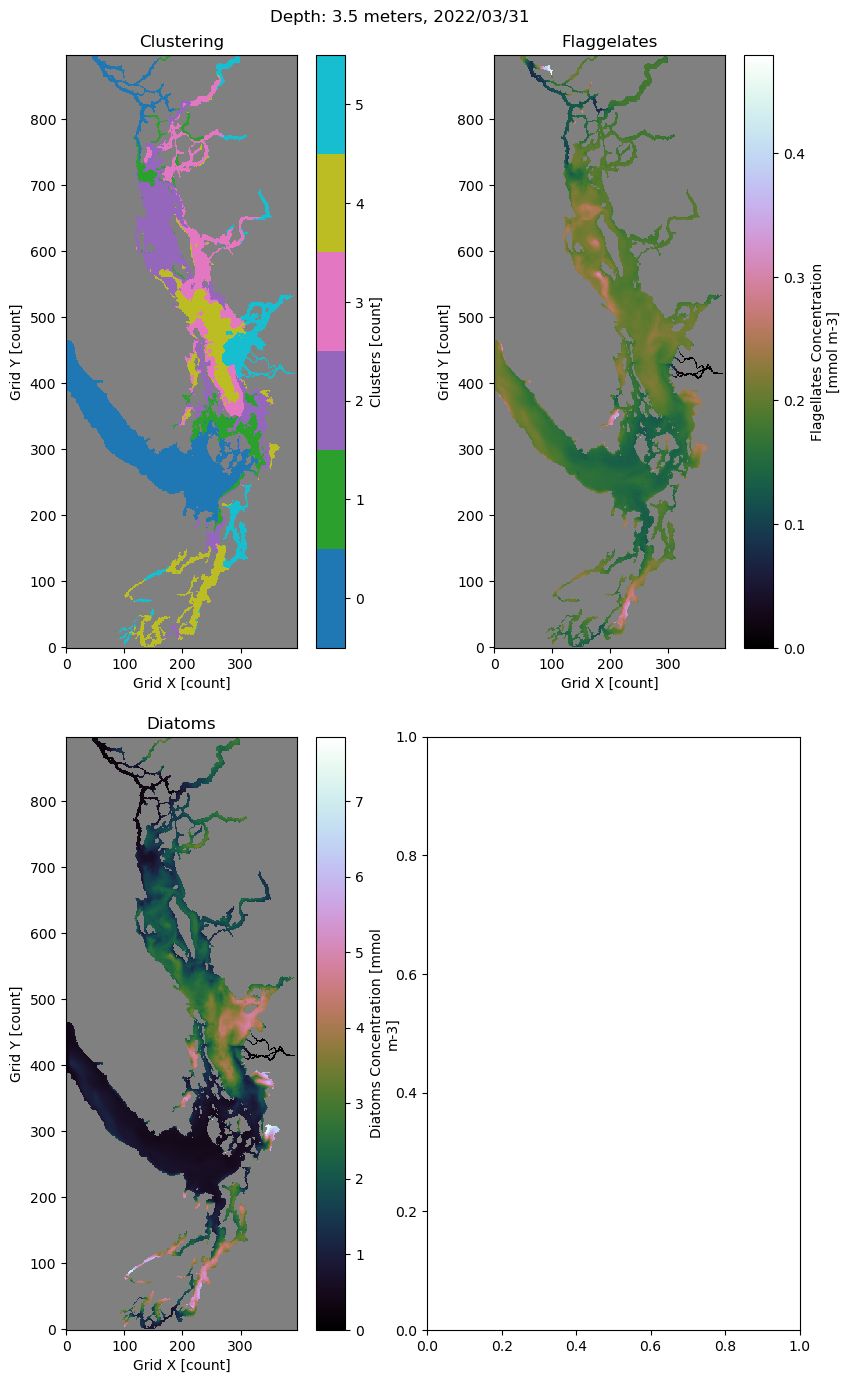

The amount of grid boxes for cluster 0 is 9028 

The minimum temperature for cluster 0 is 7.88 degrees Celsius
The maximum temperature for cluster 0 is 9.26 degrees Celsius
The mean temperature for cluster 0 is 8.26 degrees Celsius 

The minimum salinity for cluster 0 is 28.51 g/kg
The maximum salinity for cluster 0 is 30.65 g/kg
The mean salinity for cluster 0 is 29.03 g/kg 


The amount of grid boxes for cluster 1 is 24892 

The minimum temperature for cluster 1 is 6.67 degrees Celsius
The maximum temperature for cluster 1 is 8.5 degrees Celsius
The mean temperature for cluster 1 is 7.93 degrees Celsius 

The minimum salinity for cluster 1 is 28.84 g/kg
The maximum salinity for cluster 1 is 31.36 g/kg
The mean salinity for cluster 1 is 30.46 g/kg 


The amount of grid boxes for cluster 2 is 15669 

The minimum temperature for cluster 2 is 8.24 degrees Celsius
The maximum temperature for cluster 2 is 9.52 degrees Celsius
The mean temperature for cluster 2 is 8.49 degrees Celsius 

The

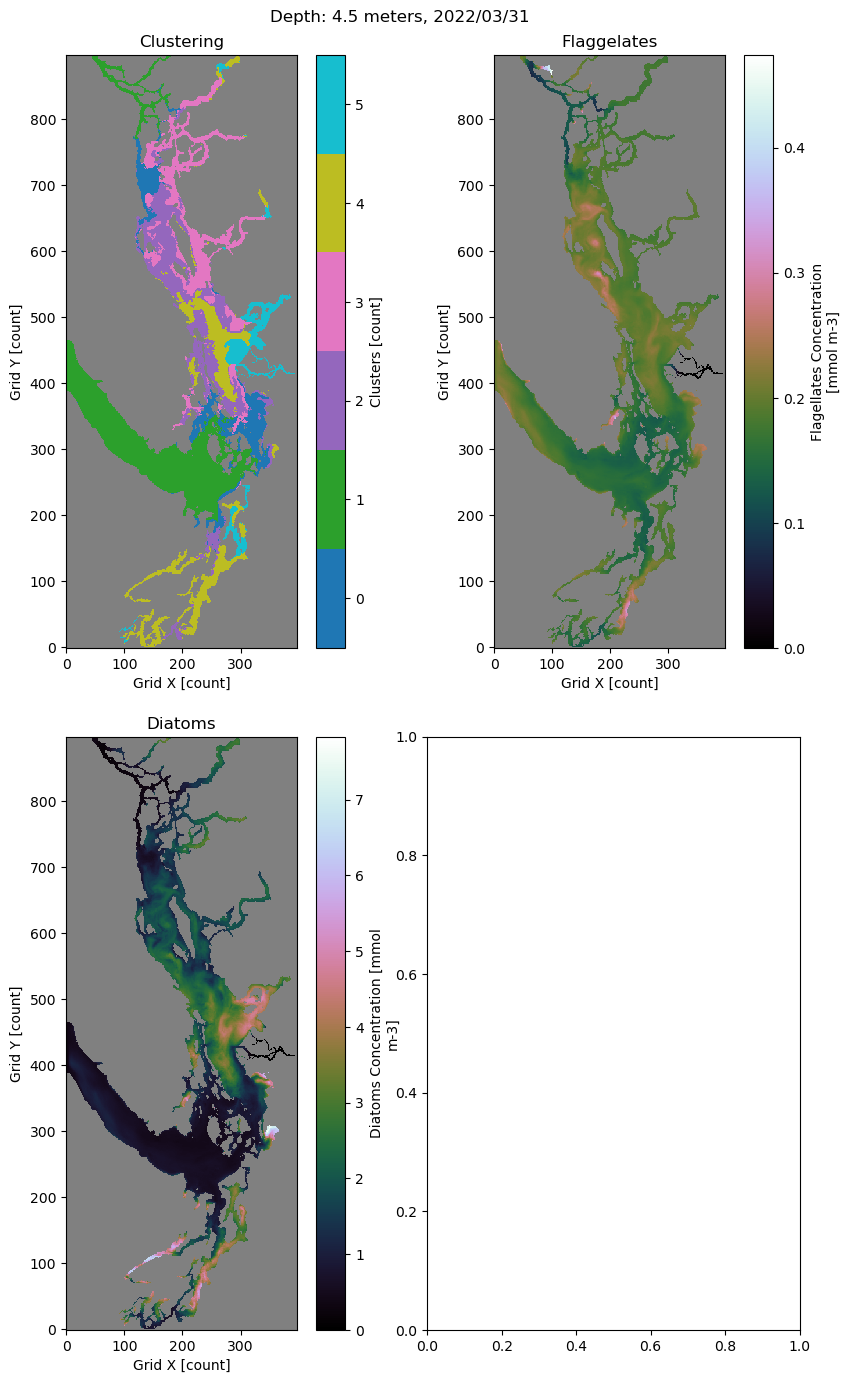

The amount of grid boxes for cluster 0 is 13984 

The minimum temperature for cluster 0 is 8.35 degrees Celsius
The maximum temperature for cluster 0 is 10.37 degrees Celsius
The mean temperature for cluster 0 is 8.86 degrees Celsius 

The minimum salinity for cluster 0 is 23.97 g/kg
The maximum salinity for cluster 0 is 29.67 g/kg
The mean salinity for cluster 0 is 27.2 g/kg 


The amount of grid boxes for cluster 1 is 6693 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 9.39 degrees Celsius
The mean temperature for cluster 1 is 8.21 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 27.49 g/kg
The mean salinity for cluster 1 is 23.79 g/kg 


The amount of grid boxes for cluster 2 is 14239 

The minimum temperature for cluster 2 is 8.06 degrees Celsius
The maximum temperature for cluster 2 is 9.07 degrees Celsius
The mean temperature for cluster 2 is 8.32 degrees Celsius 

The 

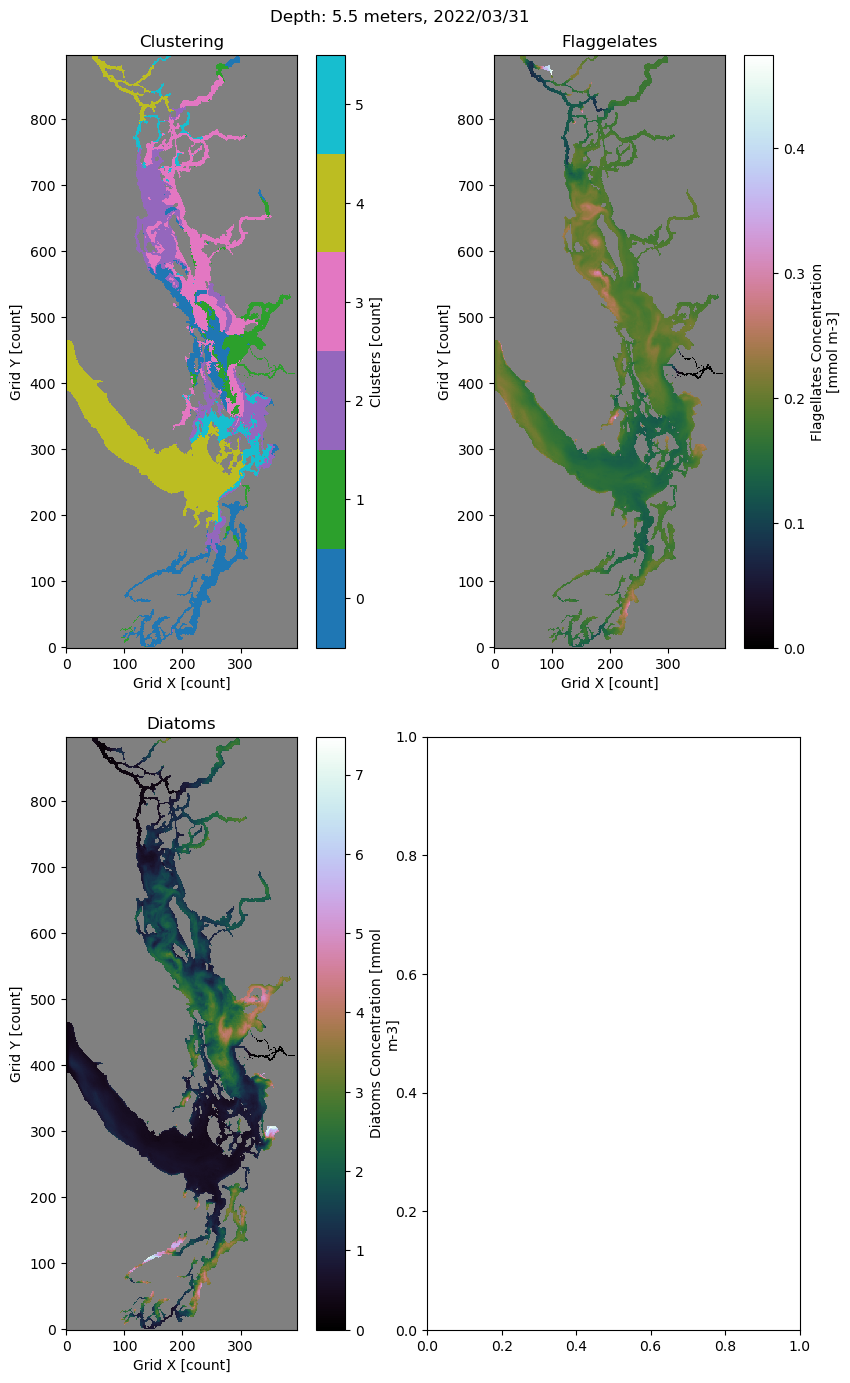

The amount of grid boxes for cluster 0 is 12443 

The minimum temperature for cluster 0 is 8.31 degrees Celsius
The maximum temperature for cluster 0 is 10.32 degrees Celsius
The mean temperature for cluster 0 is 8.83 degrees Celsius 

The minimum salinity for cluster 0 is 21.93 g/kg
The maximum salinity for cluster 0 is 29.85 g/kg
The mean salinity for cluster 0 is 27.43 g/kg 


The amount of grid boxes for cluster 1 is 8633 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 9.16 degrees Celsius
The mean temperature for cluster 1 is 8.07 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 27.84 g/kg
The mean salinity for cluster 1 is 25.63 g/kg 


The amount of grid boxes for cluster 2 is 14586 

The minimum temperature for cluster 2 is 8.1 degrees Celsius
The maximum temperature for cluster 2 is 9.02 degrees Celsius
The mean temperature for cluster 2 is 8.28 degrees Celsius 

The 

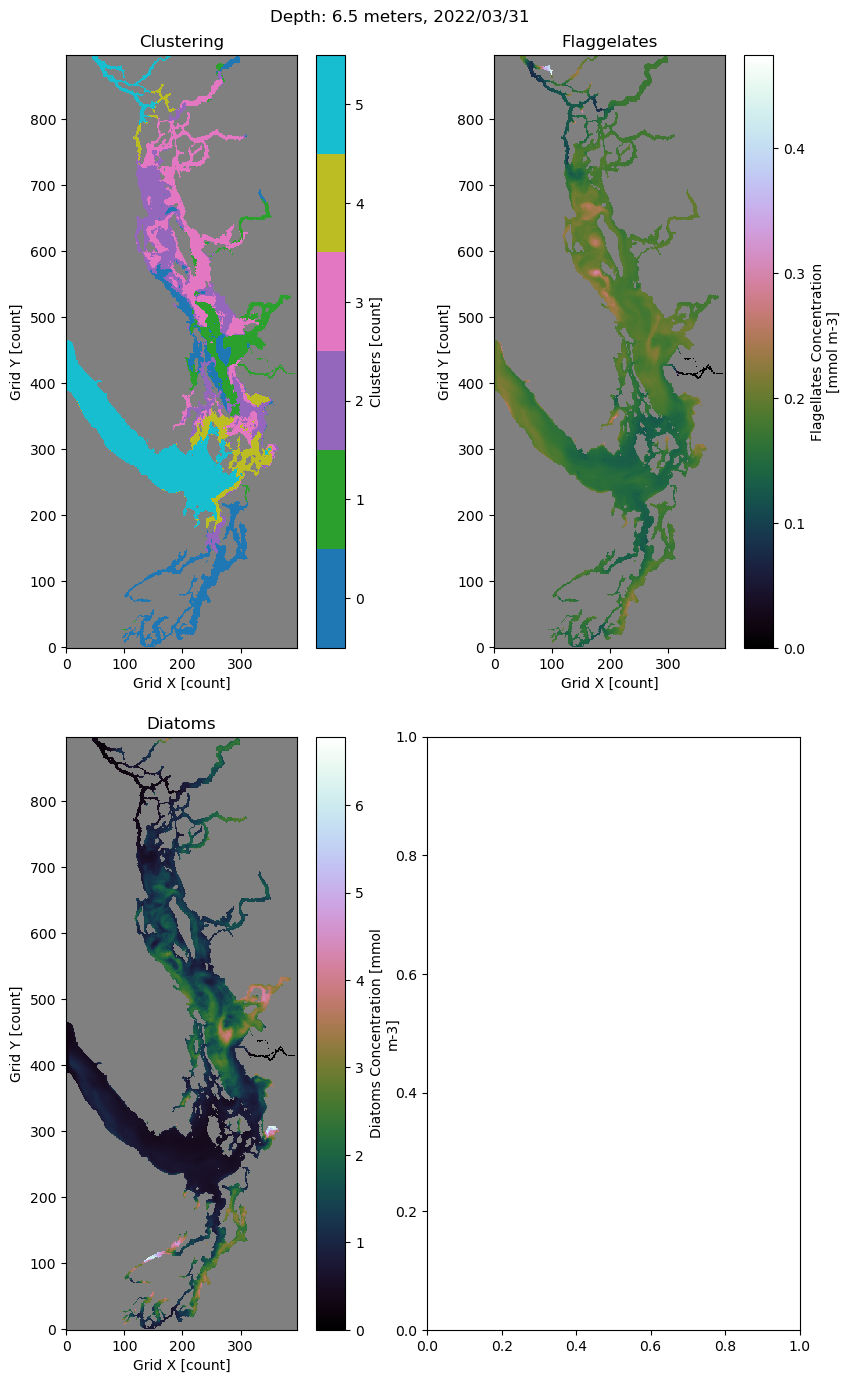

The amount of grid boxes for cluster 0 is 4622 

The minimum temperature for cluster 0 is 6.19 degrees Celsius
The maximum temperature for cluster 0 is 8.16 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 28.8 g/kg
The maximum salinity for cluster 0 is 29.88 g/kg
The mean salinity for cluster 0 is 29.45 g/kg 


The amount of grid boxes for cluster 1 is 22351 

The minimum temperature for cluster 1 is 7.4 degrees Celsius
The maximum temperature for cluster 1 is 8.76 degrees Celsius
The mean temperature for cluster 1 is 7.91 degrees Celsius 

The minimum salinity for cluster 1 is 29.63 g/kg
The maximum salinity for cluster 1 is 31.44 g/kg
The mean salinity for cluster 1 is 30.6 g/kg 


The amount of grid boxes for cluster 2 is 18827 

The minimum temperature for cluster 2 is 7.31 degrees Celsius
The maximum temperature for cluster 2 is 8.25 degrees Celsius
The mean temperature for cluster 2 is 7.91 degrees Celsius 

The m

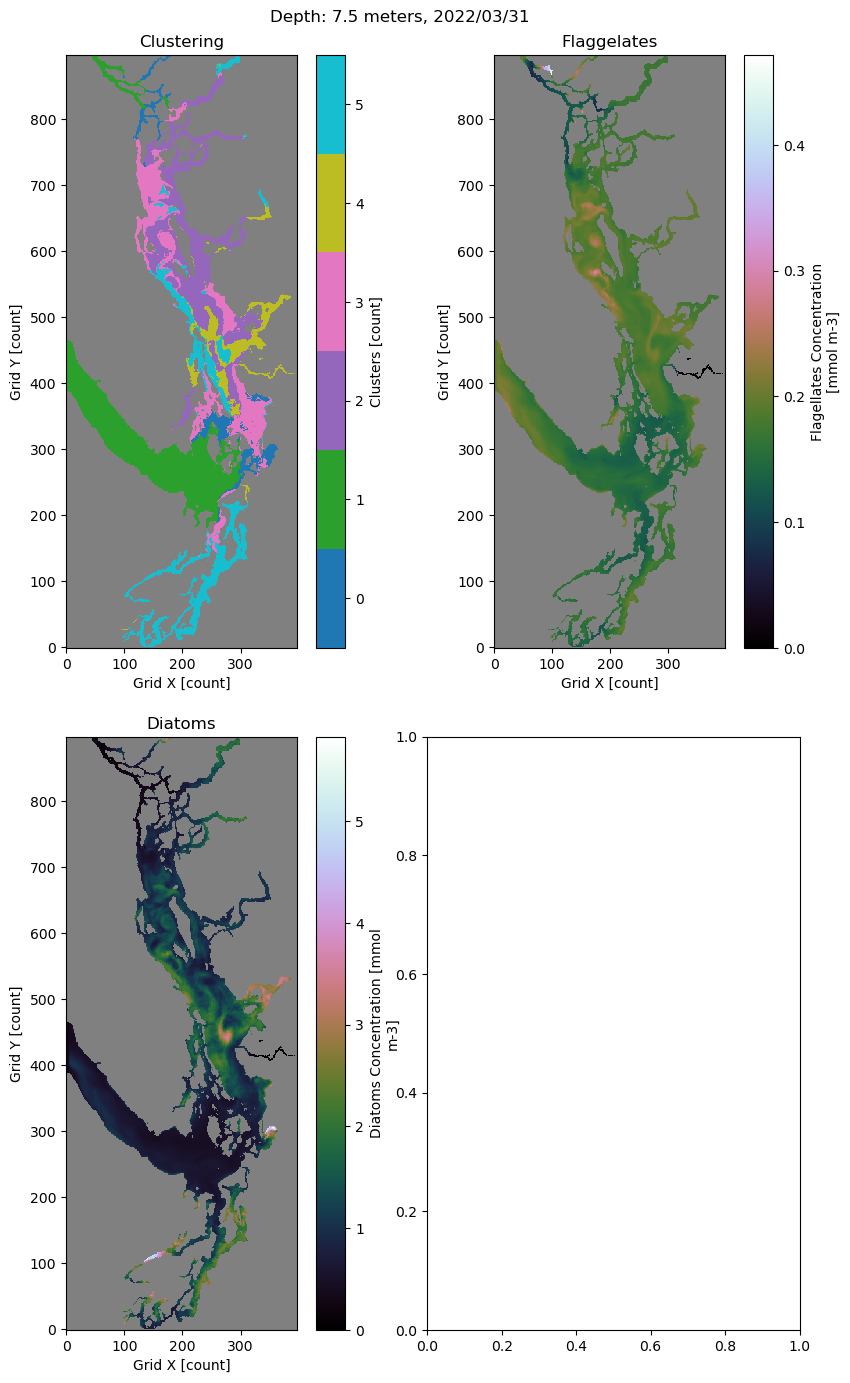

The amount of grid boxes for cluster 0 is 21599 

The minimum temperature for cluster 0 is 6.15 degrees Celsius
The maximum temperature for cluster 0 is 8.38 degrees Celsius
The mean temperature for cluster 0 is 7.87 degrees Celsius 

The minimum salinity for cluster 0 is 29.28 g/kg
The maximum salinity for cluster 0 is 31.46 g/kg
The mean salinity for cluster 0 is 30.63 g/kg 


The amount of grid boxes for cluster 1 is 5627 

The minimum temperature for cluster 1 is 7.69 degrees Celsius
The maximum temperature for cluster 1 is 8.75 degrees Celsius
The mean temperature for cluster 1 is 8.03 degrees Celsius 

The minimum salinity for cluster 1 is 29.26 g/kg
The maximum salinity for cluster 1 is 30.7 g/kg
The mean salinity for cluster 1 is 29.56 g/kg 


The amount of grid boxes for cluster 2 is 14390 

The minimum temperature for cluster 2 is 7.36 degrees Celsius
The maximum temperature for cluster 2 is 8.12 degrees Celsius
The mean temperature for cluster 2 is 7.88 degrees Celsius 

The

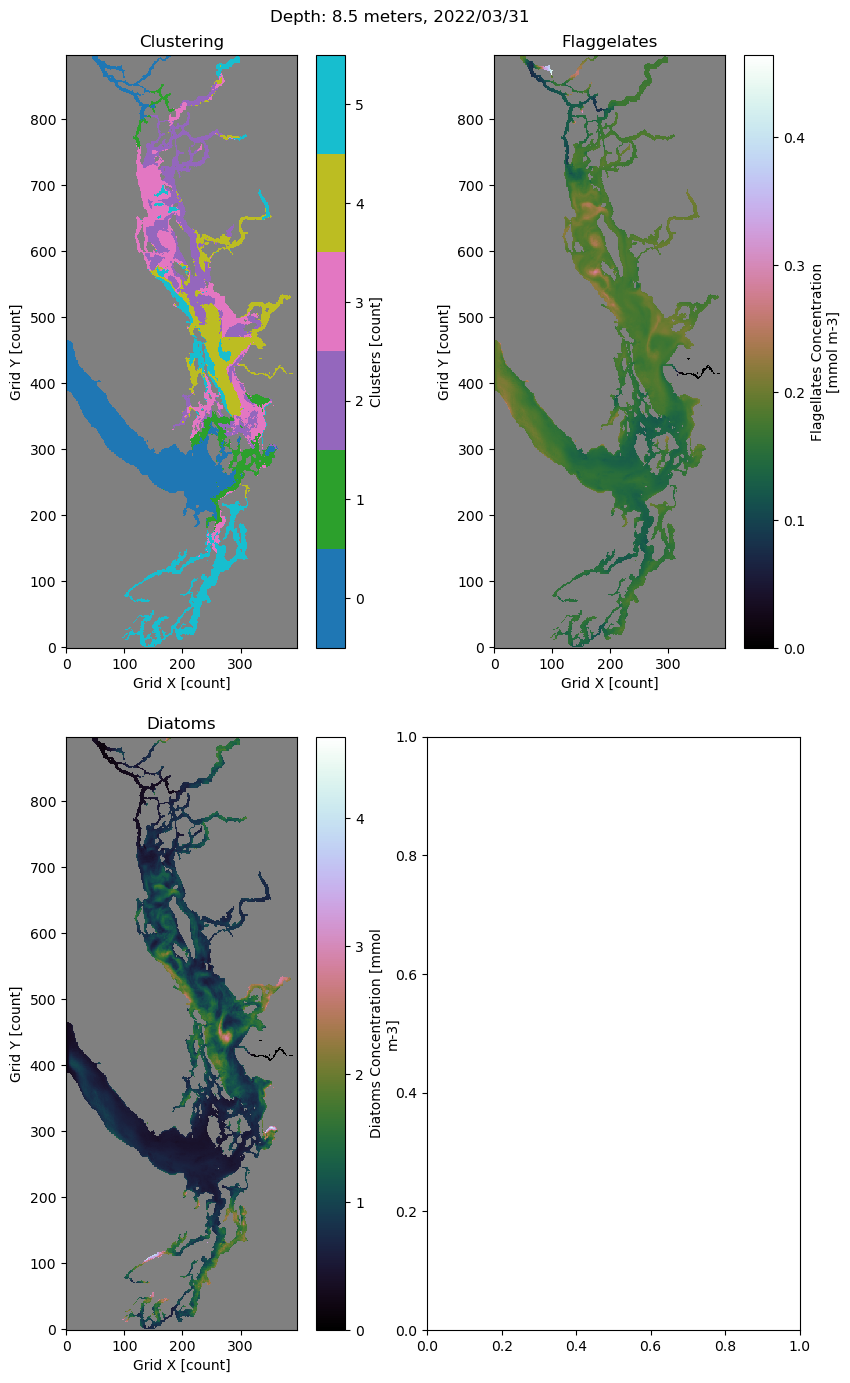

The amount of grid boxes for cluster 0 is 12874 

The minimum temperature for cluster 0 is 8.16 degrees Celsius
The maximum temperature for cluster 0 is 10.27 degrees Celsius
The mean temperature for cluster 0 is 8.67 degrees Celsius 

The minimum salinity for cluster 0 is 22.68 g/kg
The maximum salinity for cluster 0 is 29.47 g/kg
The mean salinity for cluster 0 is 28.06 g/kg 


The amount of grid boxes for cluster 1 is 5614 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 9.14 degrees Celsius
The mean temperature for cluster 1 is 7.9 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.24 g/kg
The mean salinity for cluster 1 is 26.42 g/kg 


The amount of grid boxes for cluster 2 is 17331 

The minimum temperature for cluster 2 is 8.0 degrees Celsius
The maximum temperature for cluster 2 is 8.63 degrees Celsius
The mean temperature for cluster 2 is 8.15 degrees Celsius 

The m

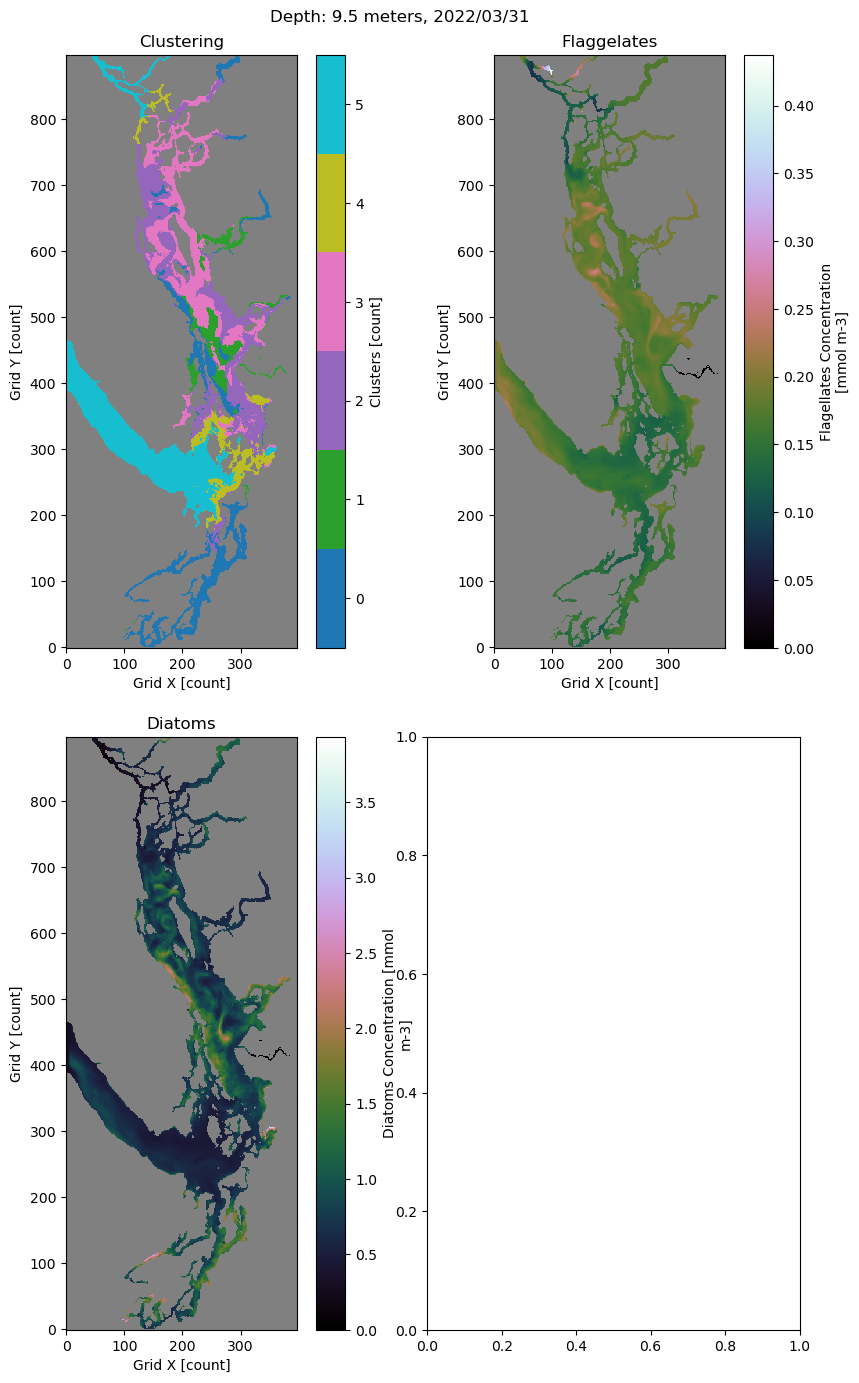

In [7]:
ds, temp, saline, date, mask, flag, diat = datasets_preparation()

for depth in range (0, 10):

    temp, saline, flag, diat = masking(depth, temp, saline, mask, flag, diat)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique, flag, diat)
